In [5]:
#importing libraries
import math
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import requests
import json
from datetime import datetime, timedelta
import gzip
import os
import time

In [6]:
# loading data set
DATA_PATH = "filtered_data_set.csv.gz" 
df = pd.read_csv(DATA_PATH,)
df


,ticker,participant_timestamp,open,high,low,close,volume
0,C:CADAUD,1,1.110320,1.113440,1.108674,1.112190,7389
1,C:SEKEUR,1,0.091874,0.092331,0.091844,0.092268,6608
2,C:CHFSGD,1,1.521120,1.525567,1.517230,1.524130,9208
3,C:NZDGBP,1,0.440910,0.441560,0.439660,0.440980,4210
4,C:HKDAUD,1,0.204219,0.205035,0.203978,0.204608,3209
...,...,...,...,...,...,...,...
189,C:INRCHF,1,0.010335,0.010359,0.010318,0.010357,6004
190,C:USDCAD,1,1.429900,1.432790,1.427240,1.430910,5974
191,C:NOKSEK,1,0.948730,0.955470,0.945950,0.954300,5536
192,C:HKDKRW,1,188.769719,188.902959,188.765472,188.900530,110


In [7]:
# Construct a directed, weighted graph in which the nodes
# are currencies and the edge weights are exchange rates.

graph = dict()

for index, row in df.iterrows():
    # Extract currency pair from ticker (e.g., C:EURUSD -> EUR, USD)
    ticker = row["ticker"]
    currency1 = ticker[2:5]  # First three characters after 'C:'
    currency2 = ticker[5:8]  # Next three characters
    open = row["open"]

    if currency1 not in graph:
        graph[currency1] = dict()
    graph[currency1][currency2] = open

print(f"Constructed graph with {len(graph)} currencies")
for curr, rates in graph.items():
    print(f"{curr}: {list(rates.keys())}")

Constructed graph with 16 currencies
CAD: ['AUD', 'EUR', 'MXN', 'KRW', 'SGD', 'CHF', 'GBP', 'SEK', 'JPY', 'HKD', 'NOK', 'USD', 'NZD', 'INR']
SEK: ['EUR', 'INR', 'CAD', 'AUD', 'GBP', 'NOK', 'CHF', 'USD', 'JPY']
CHF: ['SGD', 'AUD', 'USD', 'NOK', 'INR', 'GBP', 'SEK', 'NZD', 'KRW', 'MXN', 'JPY', 'HKD', 'CAD', 'EUR']
NZD: ['GBP', 'EUR', 'AUD', 'SEK', 'CHF', 'USD', 'CAD', 'HKD', 'MXN', 'JPY', 'NOK', 'SGD', 'KRW', 'INR']
HKD: ['AUD', 'JPY', 'MXN', 'INR', 'CHF', 'SEK', 'USD', 'GBP', 'EUR', 'NZD', 'SGD', 'CAD', 'KRW']
EUR: ['GBP', 'HKD', 'SGD', 'CHF', 'CAD', 'MXN', 'CNH', 'JPY', 'AUD', 'KRW', 'INR', 'NOK', 'USD', 'NZD', 'SEK']
GBP: ['INR', 'KRW', 'CAD', 'NZD', 'NOK', 'HKD', 'MXN', 'SGD', 'SEK', 'EUR', 'CNH', 'CHF', 'JPY', 'USD', 'AUD']
MXN: ['USD', 'SGD', 'GBP', 'HKD', 'EUR', 'JPY', 'CHF', 'CAD', 'AUD']
INR: ['EUR', 'CAD', 'SEK', 'KRW', 'SGD', 'NZD', 'GBP', 'JPY', 'AUD', 'HKD', 'USD', 'CHF']
CNH: ['HKD', 'JPY', 'USD']
SGD: ['USD', 'CAD', 'AUD', 'MXN', 'GBP', 'INR', 'HKD', 'KRW', 'SEK', 'NOK', '

C:\Users\avixa\AppData\Local\Temp\ipykernel_31580\1146994614.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


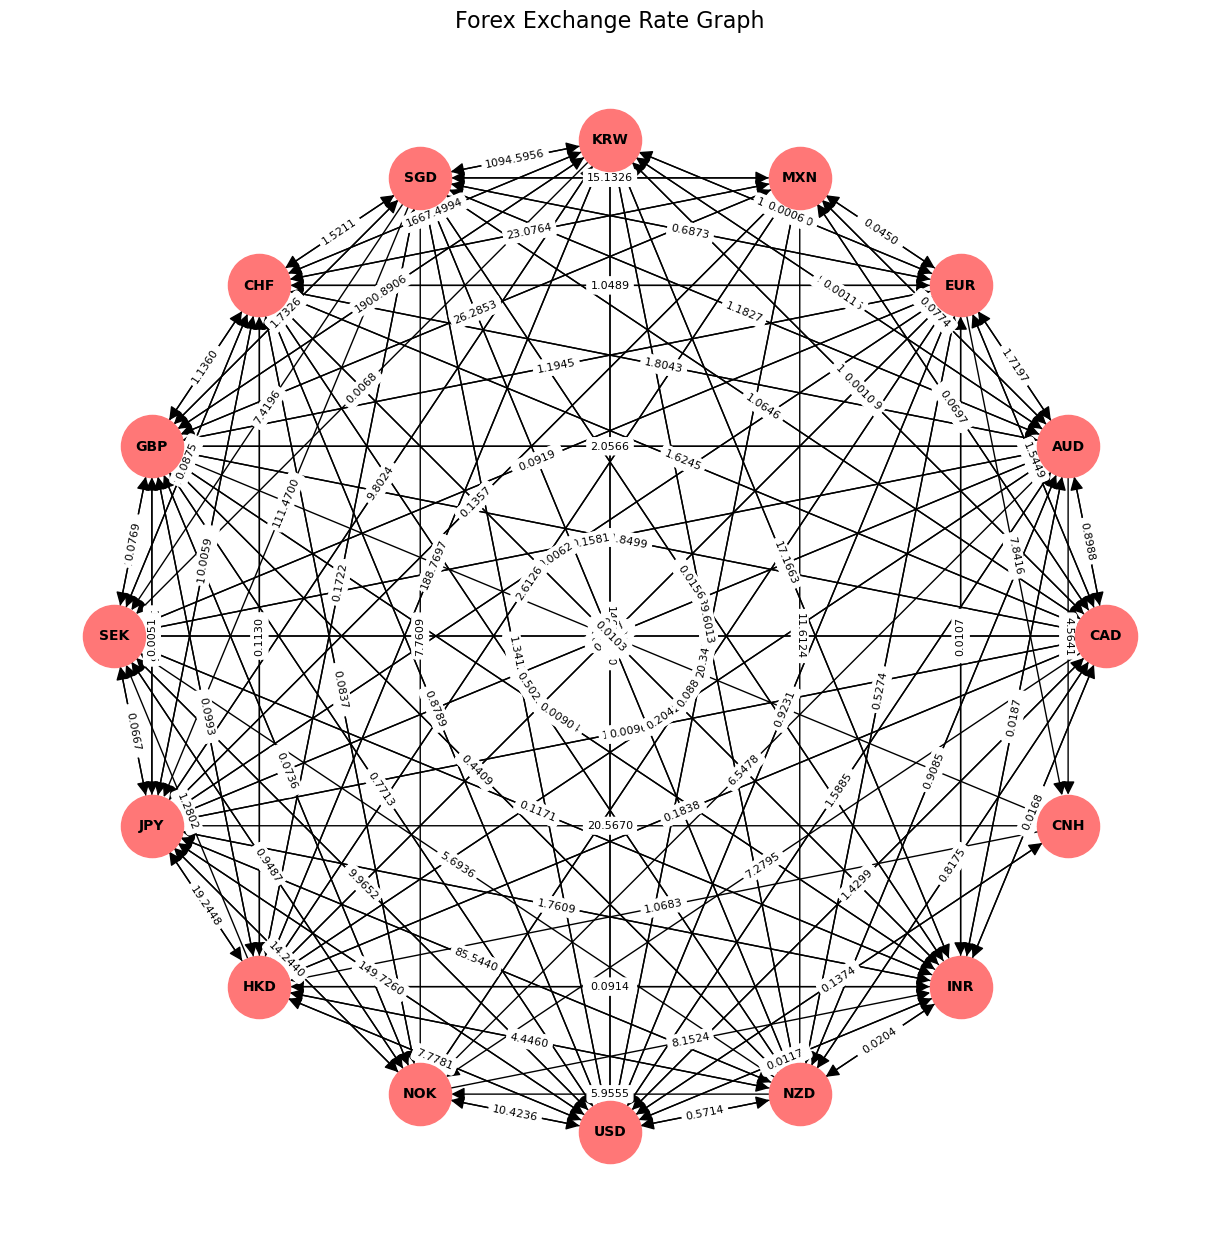

Graph has 16 nodes and 194 edges


In [8]:
# Visualize the forex graph.

G = nx.DiGraph()

for currency1, rates in graph.items():
    for currency2, rate in rates.items():
        G.add_edge(currency1, currency2, weight=rate)

# Use a circular layout instead of graphviz
pos = nx.circular_layout(G)
edge_labels = nx.get_edge_attributes(G, "weight")

plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="#FF7777", 
        font_size=10, font_weight='bold', arrows=True, arrowsize=20)

# Draw edge labels with smaller font and format exchange rates
formatted_edge_labels = {edge: f"{weight:.4f}" for edge, weight in edge_labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=formatted_edge_labels, font_size=8)

plt.title("Forex Exchange Rate Graph", size=16)
plt.axis('off')
plt.tight_layout()
plt.savefig("graph.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

In [9]:
# Simple functions to help perform arbitrage.

def graph_exchange_to_log(graph: dict[str, dict[str, float]]) -> dict[str, dict[str, float]]:
    log_graph = dict()
    for currency in graph:
        log_graph[currency] = {c: -math.log(w) for c, w in graph[currency].items()}
    return log_graph

def bellman_ford(graph: dict[str, dict[str, float]]) -> list:
    # Create a new graph in which each weight is the negative logarithm of the exchange rate.
    graph = graph_exchange_to_log(graph)

    # Add a sentinel source node with a weight 0 edge to each node.
    graph["\0"] = {c: 0 for c in graph}

    # Initialize the Bellman-Ford data structures.
    distance = {c: float("inf") for c in graph}
    distance["\0"] = 0
    predecessor = {c: None for c in graph}

    # Relax the edges V - 1 times.
    for _ in range(len(graph) - 1):
        for c1 in graph:
            for c2 in graph[c1]:
                weight = graph[c1][c2]
                if distance[c1] + weight < distance[c2]:
                    distance[c2] = distance[c1] + weight
                    predecessor[c2] = c1

    # Find all negative cycles
    negative_cycles = []
    processed_nodes = set()
    
    for c1 in graph:
        for c2 in graph[c1]:
            weight = graph[c1][c2]
            if distance[c1] + weight < distance[c2] and c2 not in processed_nodes:
                # Found a negative cycle, trace it back
                visited = {c: False for c in graph}
                current = c2
                
                # Follow predecessors until we find the cycle
                while current and not visited.get(current, False):
                    visited[current] = True
                    current = predecessor[current]
                
                if current:  # We found a cycle
                    cycle = [current]
                    next_node = predecessor[current]
                    while next_node != current:
                        cycle.insert(0, next_node)
                        next_node = predecessor[next_node]
                    
                    # Mark all nodes in this cycle as processed
                    for node in cycle:
                        processed_nodes.add(node)
                    
                    negative_cycles.append(cycle)

    return negative_cycles

result = bellman_ford(graph)
if result:
    print(f"Found {len(result)} negative cycle(s):")
    for i, cycle in enumerate(result, 1):
        print(f"Cycle {i}: {' -> '.join(cycle)} -> {cycle[0]}")
else:
    print("No negative cycles found")

Found 24 negative cycle(s):
Cycle 1: JPY -> KRW -> INR -> JPY
Cycle 2: JPY -> KRW -> INR -> JPY
Cycle 3: JPY -> KRW -> INR -> JPY
Cycle 4: KRW -> INR -> JPY -> KRW
Cycle 5: KRW -> INR -> JPY -> KRW
Cycle 6: KRW -> INR -> JPY -> KRW
Cycle 7: JPY -> KRW -> INR -> JPY
Cycle 8: KRW -> INR -> JPY -> KRW
Cycle 9: JPY -> KRW -> INR -> JPY
Cycle 10: JPY -> KRW -> INR -> JPY
Cycle 11: JPY -> KRW -> INR -> JPY
Cycle 12: KRW -> INR -> JPY -> KRW
Cycle 13: KRW -> INR -> JPY -> KRW
Cycle 14: JPY -> KRW -> INR -> JPY
Cycle 15: KRW -> INR -> JPY -> KRW
Cycle 16: JPY -> KRW -> INR -> JPY
Cycle 17: KRW -> INR -> JPY -> KRW
Cycle 18: JPY -> KRW -> INR -> JPY
Cycle 19: JPY -> KRW -> INR -> JPY
Cycle 20: JPY -> KRW -> INR -> JPY
Cycle 21: KRW -> INR -> JPY -> KRW
Cycle 22: KRW -> INR -> JPY -> KRW
Cycle 23: JPY -> KRW -> INR -> JPY
Cycle 24: KRW -> INR -> JPY -> KRW
